## 1. System Information and GPU Detection

In [1]:
import torch
import sys

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"\nCUDA (ROCm) available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("No GPU detected - running on CPU")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

Python version: 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
PyTorch version: 2.8.0+rocm7.1.0.git7a520360

CUDA (ROCm) available: True
CUDA version: None
Number of GPUs: 1
Current GPU: 0
GPU Name: AMD Radeon Graphics
GPU Memory: 31.04 GB

Using device: cuda


## 2. Import Required Libraries

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

print("Libraries imported successfully")

Libraries imported successfully


## 3. Create Synthetic Dataset

We'll create a simple binary classification dataset with 2 features.

Dataset created with 1000 samples


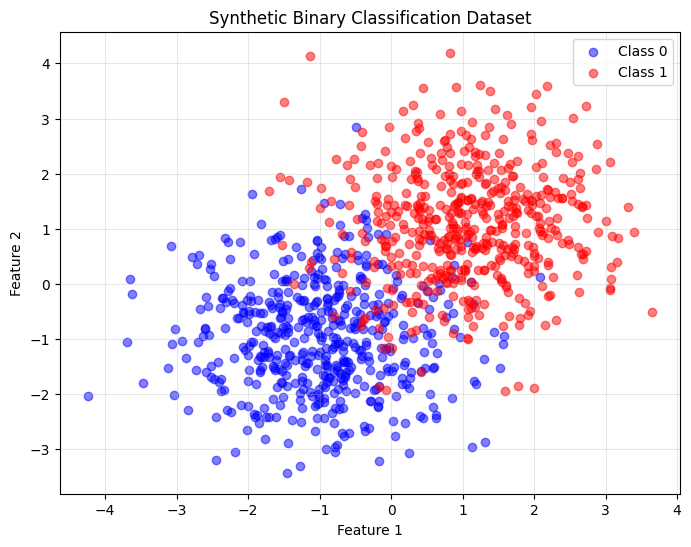

In [3]:
class SyntheticDataset(Dataset):
    def __init__(self, n_samples=1000, n_features=2, random_state=42):
        np.random.seed(random_state)
        
        # Generate synthetic data for binary classification
        # Class 0: centered around (-1, -1)
        # Class 1: centered around (1, 1)
        class_0 = np.random.randn(n_samples // 2, n_features) + np.array([-1, -1])
        class_1 = np.random.randn(n_samples // 2, n_features) + np.array([1, 1])
        
        self.X = np.vstack([class_0, class_1]).astype(np.float32)
        self.y = np.hstack([np.zeros(n_samples // 2), np.ones(n_samples // 2)]).astype(np.float32)
        
        # Shuffle the data
        indices = np.random.permutation(n_samples)
        self.X = self.X[indices]
        self.y = self.y[indices]
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

# Create dataset
dataset = SyntheticDataset(n_samples=1000, n_features=2)
print(f"Dataset created with {len(dataset)} samples")

# Visualize the data
X_numpy = dataset.X
y_numpy = dataset.y

plt.figure(figsize=(8, 6))
plt.scatter(X_numpy[y_numpy == 0][:, 0], X_numpy[y_numpy == 0][:, 1], 
           c='blue', label='Class 0', alpha=0.5)
plt.scatter(X_numpy[y_numpy == 1][:, 0], X_numpy[y_numpy == 1][:, 1], 
           c='red', label='Class 1', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Synthetic Binary Classification Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Split Data and Create DataLoaders

In [4]:
# Split dataset into train (70%), validation (15%), and test (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

Train samples: 700
Validation samples: 150
Test samples: 150
Batch size: 32


## 5. Define Sequential Neural Network

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, output_size=1):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize model
model = SimpleNN(input_size=2, hidden_size=16, output_size=1).to(device)
print(model)
print(f"\nModel has {sum(p.numel() for p in model.parameters())} parameters")
print(f"Model is on device: {next(model.parameters()).device}")

SimpleNN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Model has 337 parameters
Model is on device: cuda:0


## 6. Define Loss Function and Optimizer

In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss function: BCELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


## 7. Training Function

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1)  # Add dimension for BCELoss
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

print("Training function defined")

Training function defined


## 8. Evaluation Function

In [8]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

print("Evaluation function defined")

Evaluation function defined


## 9. Train the Model

In [9]:
num_epochs = 50
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("Starting training...\n")

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n")

print("Training complete!")

Starting training...

Epoch [10/50]
  Train Loss: 0.1833, Train Acc: 0.9257
  Val Loss: 0.1904, Val Acc: 0.8933

Epoch [20/50]
  Train Loss: 0.1841, Train Acc: 0.9214
  Val Loss: 0.1973, Val Acc: 0.9000

Epoch [30/50]
  Train Loss: 0.1850, Train Acc: 0.9229
  Val Loss: 0.2021, Val Acc: 0.9000

Epoch [40/50]
  Train Loss: 0.1818, Train Acc: 0.9257
  Val Loss: 0.1916, Val Acc: 0.9000

Epoch [50/50]
  Train Loss: 0.1762, Train Acc: 0.9314
  Val Loss: 0.2000, Val Acc: 0.9000

Training complete!


## 10. Plot Training History

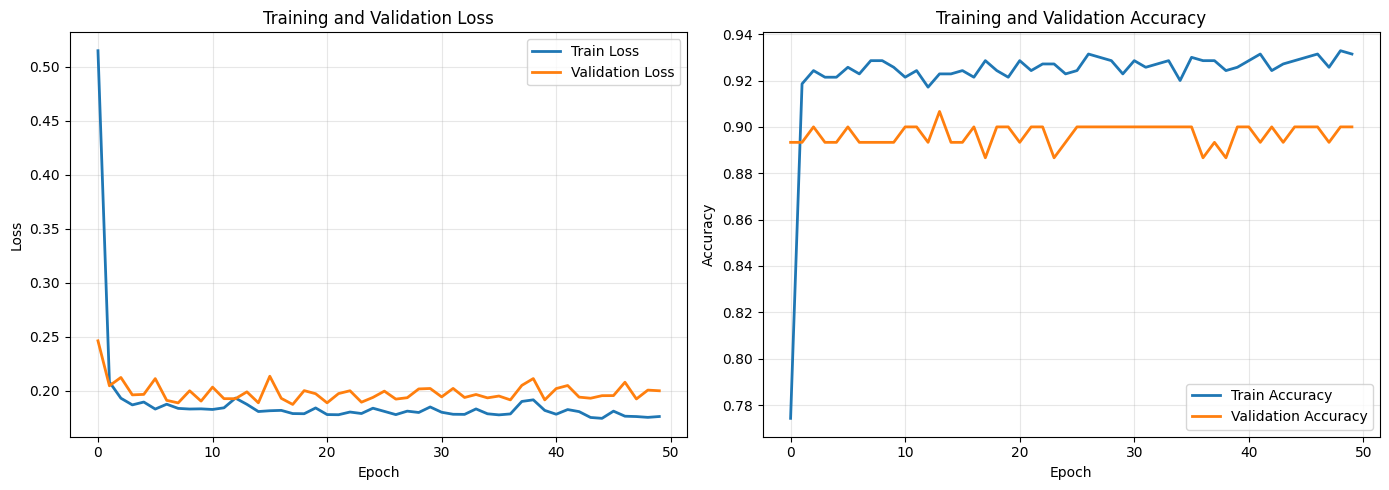

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Test the Model

In [11]:
# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("\n" + "="*50)
print("TEST RESULTS")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("="*50)


TEST RESULTS
Test Loss: 0.1912
Test Accuracy: 0.9333


## 12. Detailed Test Metrics

In [12]:
# Get predictions for all test samples
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions = (outputs > 0.5).float().cpu().numpy()
        
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions).flatten()
all_labels = np.array(all_labels)

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, 
                          target_names=['Class 0', 'Class 1'],
                          digits=4))


Classification Report:
              precision    recall  f1-score   support

     Class 0     0.9167    0.9625    0.9390        80
     Class 1     0.9545    0.9000    0.9265        70

    accuracy                         0.9333       150
   macro avg     0.9356    0.9313    0.9327       150
weighted avg     0.9343    0.9333    0.9332       150



## 13. Visualize Decision Boundary

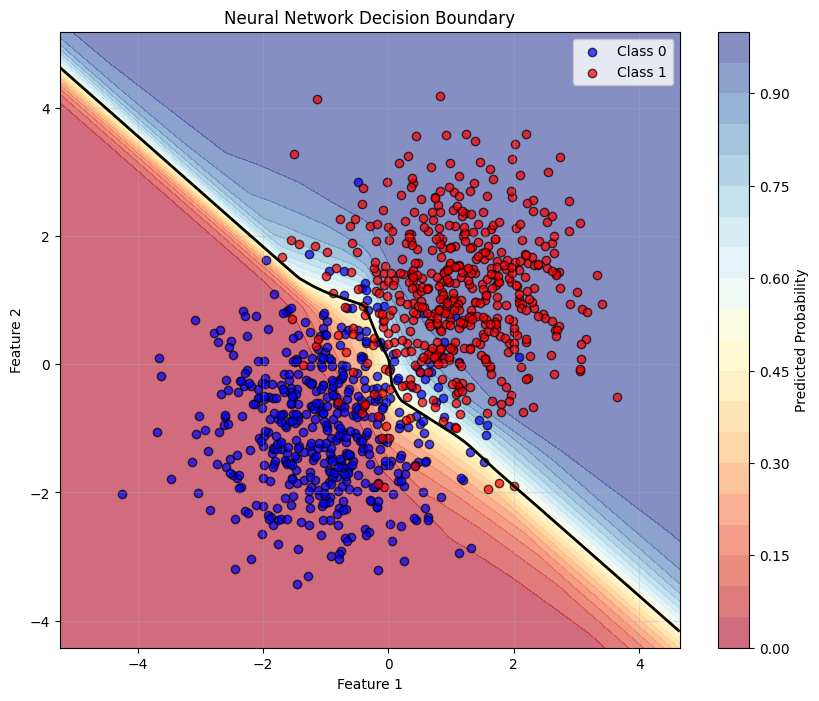

In [13]:
# Create a mesh grid
x_min, x_max = X_numpy[:, 0].min() - 1, X_numpy[:, 0].max() + 1
y_min, y_max = X_numpy[:, 1].min() - 1, X_numpy[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on mesh grid
model.eval()
with torch.no_grad():
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    Z = model(grid_points).cpu().numpy()
    Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
plt.colorbar(label='Predicted Probability')
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

# Plot data points
plt.scatter(X_numpy[y_numpy == 0][:, 0], X_numpy[y_numpy == 0][:, 1], 
           c='blue', label='Class 0', alpha=0.7, edgecolors='black')
plt.scatter(X_numpy[y_numpy == 1][:, 0], X_numpy[y_numpy == 1][:, 1], 
           c='red', label='Class 1', alpha=0.7, edgecolors='black')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Neural Network Decision Boundary')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary

This notebook demonstrated:
- ✅ GPU/CUDA (ROCm) detection and device information
- ✅ Creating a custom PyTorch Dataset with synthetic data
- ✅ Using DataLoader for efficient batch processing
- ✅ Building a sequential neural network
- ✅ Training loop with proper train/validation split
- ✅ Model evaluation on test set
- ✅ Visualization of results and decision boundaries

The model successfully learned to classify the synthetic binary dataset with high accuracy!